In [1]:
%matplotlib inline

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(123)

# Lee (2008)

We study the effect of incumbency on the next election.

* Lee, David S. (2008). Randomized experiments from non-random selection in U.S. House elections. Journal of Econometrics.

In [2]:
df_base = pd.read_csv('../../datasets/processed/msc/house.csv')
df_base.head()

,vote_last,vote_next,D
0,0.1049,0.5810,True
1,0.1393,0.4611,True
2,-0.0736,0.5434,False
3,0.0868,0.5846,True
4,0.3994,0.5803,True


## What are the basic characteristics of the dataset?

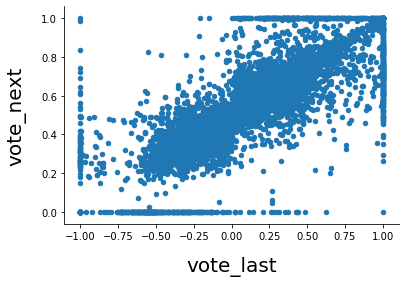

In [3]:
df_base.plot.scatter(x=0, y=1)

How does the average vote in the next election look like as we move along last year's election.

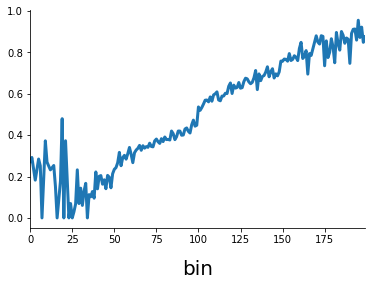

In [20]:
df_base['bin'] = pd.cut(df_base.vote_last, 200, labels=False)
df_base.groupby('bin').vote_next.mean().plot();

Now we turn to an explicit model of the conditional mean.

In [15]:
def fit_regression(incumbent, level=4):
    assert incumbent in ['republican', 'democratic']

    if incumbent == 'republican':
        df_incumbent = df_base.loc[df_base.vote_last < 0.0, :]
    else:
        df_incumbent = df_base.loc[df_base.vote_last > 0.0, :]

    for level in range(2, level + 1):
        label = 'vote_last_{:}'.format(level)
        df_incumbent.loc[:, label] = df_incumbent['vote_last'] ** level

    formula = 'vote_next ~ vote_last + vote_last_2 + vote_last_3 + vote_last_4'
    rslt = smf.ols(formula=formula, data=df_incumbent).fit()
    
    return rslt

rslt = dict()
for incumbent in ['republican', 'democratic']:
    rslt = fit_regression(incumbent, level=4)
    title = '\n\n {:}\n'.format(incumbent.capitalize())
    print(title, rslt.summary())



 Republican
                             OLS Regression Results                            
Dep. Variable:              vote_next   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     262.5
Date:                Tue, 04 Jun 2019   Prob (F-statistic):          4.33e-191
Time:                        06:58:08   Log-Likelihood:                 1761.3
No. Observations:                2740   AIC:                            -3513.
Df Residuals:                    2735   BIC:                            -3483.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4542      0.009  

How does the predictions look like?

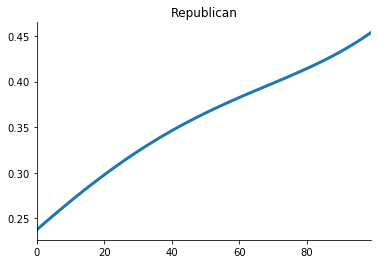

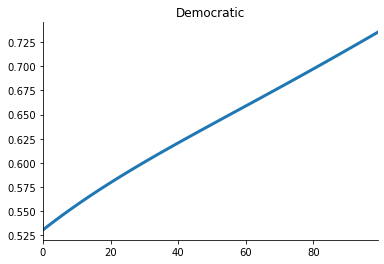

In [19]:
for incumbent in ['republican', 'democratic']:
    
    rslt = fit_regression(incumbent, level=4)
    
    # For our predictions, we need to set up a grid for the evaluation.
    if incumbent == 'republican':
        grid = np.linspace(-0.5, 0.0, 100)
    else:
        grid = np.linspace(+0.0, 0.5, 100)
        
    df_grid = pd.DataFrame(grid, columns=['vote_last'])
    for level in range(2, 5):
        label = 'vote_last_{:}'.format(level)
        df_grid.loc[:, label] = df_grid['vote_last'] ** level

    ax = rslt.predict(df_grid).plot(title=incumbent.capitalize());
    plt.show()

We can now compute the difference at the cutoffs to get an estimate for the treatment effect.

In [7]:
before_cutoff = df_base.groupby('bin')['vote_next'].mean()[99]
after_cutoff = df_base.groupby('bin')['vote_next'].mean()[100]

effect = after_cutoff - before_cutoff
print('Treatment Effect: {:5.3f}%'.format(effect * 100))

Treatment Effect: 8.823%


## How does the estimated treatment effect depend on the choice of the bin width?

In [21]:
for num_bins in [100, 200]:
    df = df_base.copy(deep=True) 
    df['bin'] = pd.cut(df_base.vote_last, num_bins, labels=False)
    info = df.groupby('bin').vote_next.mean() 
    lower = (num_bins / 2) - 1
    effect = info[lower + 1] - info[lower]
    print(' Number of bins: {:}, Width {:>5}, Effect {:5.2f}%'.format(num_bins, 1.0 / num_bins, effect * 100))

 Number of bins: 100, Width  0.01, Effect  8.12%
 Number of bins: 200, Width 0.005, Effect  8.82%


## Regression 

There are several alternatives to estimate the conditional mean functions.

* pooled regressions

* local linear regressions

### Pooled regression

We estimate the conditinal mean using the whole function.

\begin{align*}
Y = \alpha_r + \tau D + \beta X + \epsilon
\end{align*}

This allows for a difference in levels but not slope.


In [9]:
smf.ols(formula='vote_next ~ vote_last + D', data=df_base).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              vote_next   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     6658.
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        06:41:20   Log-Likelihood:                 3661.9
No. Observations:                6558   AIC:                            -7318.
Df Residuals:                    6555   BIC:                            -7298.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4427      0.003    139.745      0.000       0.437       0.449
D[T.True]      0.1137      0.006     20.572      0.000       0.103       0.125
vote_last      0.3305      0.006     55.186      0.000       0.319       0.342
==============================================================================
Omnibus:                      595.910   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3444.243
Skew:                          -0.225   Prob(JB):                         0.00
Kurtosis:                       6.522   Cond. No.                         5.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Local linear regression

We now turn to local regressions by restricting the estimation to observations close to the cutoff.

\begin{align*}
Y = \alpha_r + \tau D + \beta X + \gamma X D + \epsilon,
\end{align*}

where $-h \geq X \geq h$. This allows for a difference in levels and slope.

In [ ]:
for h in [0.3, 0.2, 0.1, 0.05, 0.01]:
    # We restrict the sample to observations close
    # to the cutoff.
    df = df_base[df_base.vote_last.between(-h, h)]
    
    formula = 'vote_next ~ D + vote_last + D * vote_last'
    rslt = smf.ols(formula=formula, data=df).fit()
    info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
    print(' Bandwidth: {:>4}   Effect {:5.3f}%    pvalue {:5.3f}'.format(*info))

There exists some work that can guide the choice of the bandwidth.

Now, let's return to the slides to summarize the key issues and some review best practices.